In [15]:
import numpy as np
import pandas as pd 
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!pip uninstall -q tensorboard tb-nightly
!pip install -q tb-nightly
%pylab inline
%load_ext tensorboard
import torch.utils.tensorboard as tb
import tempfile
log_dir=tempfile.mkdtemp()

Proceed (y/n)? y
     |████████████████████████████████| 6.0 MB 5.3 MB/s 
Populating the interactive namespace from numpy and matplotlib


In [ ]:
%tensorboard --logdir {log_dir} --reload_interval 1

In [ ]:
logger=tb.SummaryWriter(log_dir+'/test',flush_secs=1)

In [ ]:

train_transformations = transforms.Compose([ 
transforms.RandomHorizontalFlip(),
transforms.RandomRotation((-7,7)),
transforms.ToTensor(),
transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
])


test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transformations)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
class ResNetBlock(nn.Module):
    expansion = 1
    

    def __init__(self, in_planes, planes, stride=1):
        super(ResNetBlock, self).__init__()

        DROPOUT = 0.1

        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes),
                nn.Dropout(DROPOUT)
            )

    def forward(self, x):
        out = F.relu(self.dropout(self.bn1(self.conv1(x))))
        out = self.dropout(self.bn2(self.conv2(out)))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [9]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return F.log_softmax(out, dim=-1)

In [10]:
def ResNet18():
    return ResNet(ResNetBlock, [2, 2, 2, 2])

In [ ]:
model=ResNet18().to(device)
summary(model, input_size=(3,32,32))

In [ ]:
def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):
            
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        

        train_losses.append(loss)
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        running_loss += loss.item()
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

In [ ]:
def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):
    
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)

In [20]:
train_acc = []
train_losses = []
test_acc = []
test_losses = []
total_step = len(train_loader)
EPOCHS = 2

In [21]:
for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, train_loader, optimizer, train_acc, train_losses)
    scheduler.step(train_losses[-1])
    misclassified = model_testing(model, device, test_loader, test_acc, test_losses)

EPOCHS : 0


Loss=1.185065746307373 Batch_id=390 Accuracy=49.43: 100%|██████████| 391/391 [59:14<00:00,  9.09s/it]



Test set: Average loss: 1.1430, Accuracy: 6081/10000 (60.81%)

EPOCHS : 1


Loss=0.9919857978820801 Batch_id=390 Accuracy=67.23: 100%|██████████| 391/391 [59:11<00:00,  9.08s/it]



Test set: Average loss: 0.8627, Accuracy: 7023/10000 (70.23%)



In [29]:
print(train_acc)

[19.53125, 23.4375, 26.822916666666668, 25.1953125, 25.625, 26.302083333333332, 25.669642857142858, 25.78125, 26.041666666666668, 25.9375, 26.136363636363637, 26.041666666666668, 25.841346153846153, 25.558035714285715, 25.520833333333332, 25.5859375, 26.011029411764707, 26.34548611111111, 26.52138157894737, 26.5625, 26.93452380952381, 27.166193181818183, 27.51358695652174, 27.604166666666668, 27.4375, 27.82451923076923, 28.35648148148148, 28.180803571428573, 28.502155172413794, 28.489583333333332, 28.704637096774192, 28.90625, 29.332386363636363, 29.27389705882353, 29.375, 29.557291666666668, 29.77195945945946, 30.03700657894737, 30.108173076923077, 30.46875, 30.621189024390244, 30.636160714285715, 30.577761627906977, 30.6640625, 30.833333333333332, 30.94429347826087, 31.16688829787234, 31.396484375, 31.536989795918366, 31.84375, 32.03125, 32.15144230769231, 32.3997641509434, 32.523148148148145, 32.59943181818182, 32.8125, 32.97697368421053, 33.216594827586206, 33.35540254237288, 33.54

In [27]:
trainloss=[tensor.item() for tensor in train_losses]
print(trainloss)

[2.1021385192871094, 2.0394880771636963, 1.978767991065979, 2.0012073516845703, 2.1239285469055176, 1.923048973083496, 1.9266760349273682, 2.1452043056488037, 1.8088960647583008, 1.9105650186538696, 1.9084155559539795, 1.88132643699646, 2.010579824447632, 1.9518952369689941, 1.9603567123413086, 1.9088009595870972, 1.8246264457702637, 1.9079924821853638, 1.7455934286117554, 1.9227441549301147, 1.7911348342895508, 1.8706316947937012, 1.7665773630142212, 1.8290461301803589, 1.9821832180023193, 1.9261587858200073, 1.6785225868225098, 1.8800010681152344, 1.6561003923416138, 1.8225979804992676, 1.697379231452942, 1.6464753150939941, 1.681845784187317, 1.8986445665359497, 1.871335744857788, 1.747544527053833, 1.719104290008545, 1.589943289756775, 1.7278053760528564, 1.6858278512954712, 1.8287612199783325, 1.8338948488235474, 1.8407187461853027, 1.7310837507247925, 1.6555683612823486, 1.649733304977417, 1.6792970895767212, 1.5780432224273682, 1.6385760307312012, 1.5663905143737793, 1.487058281

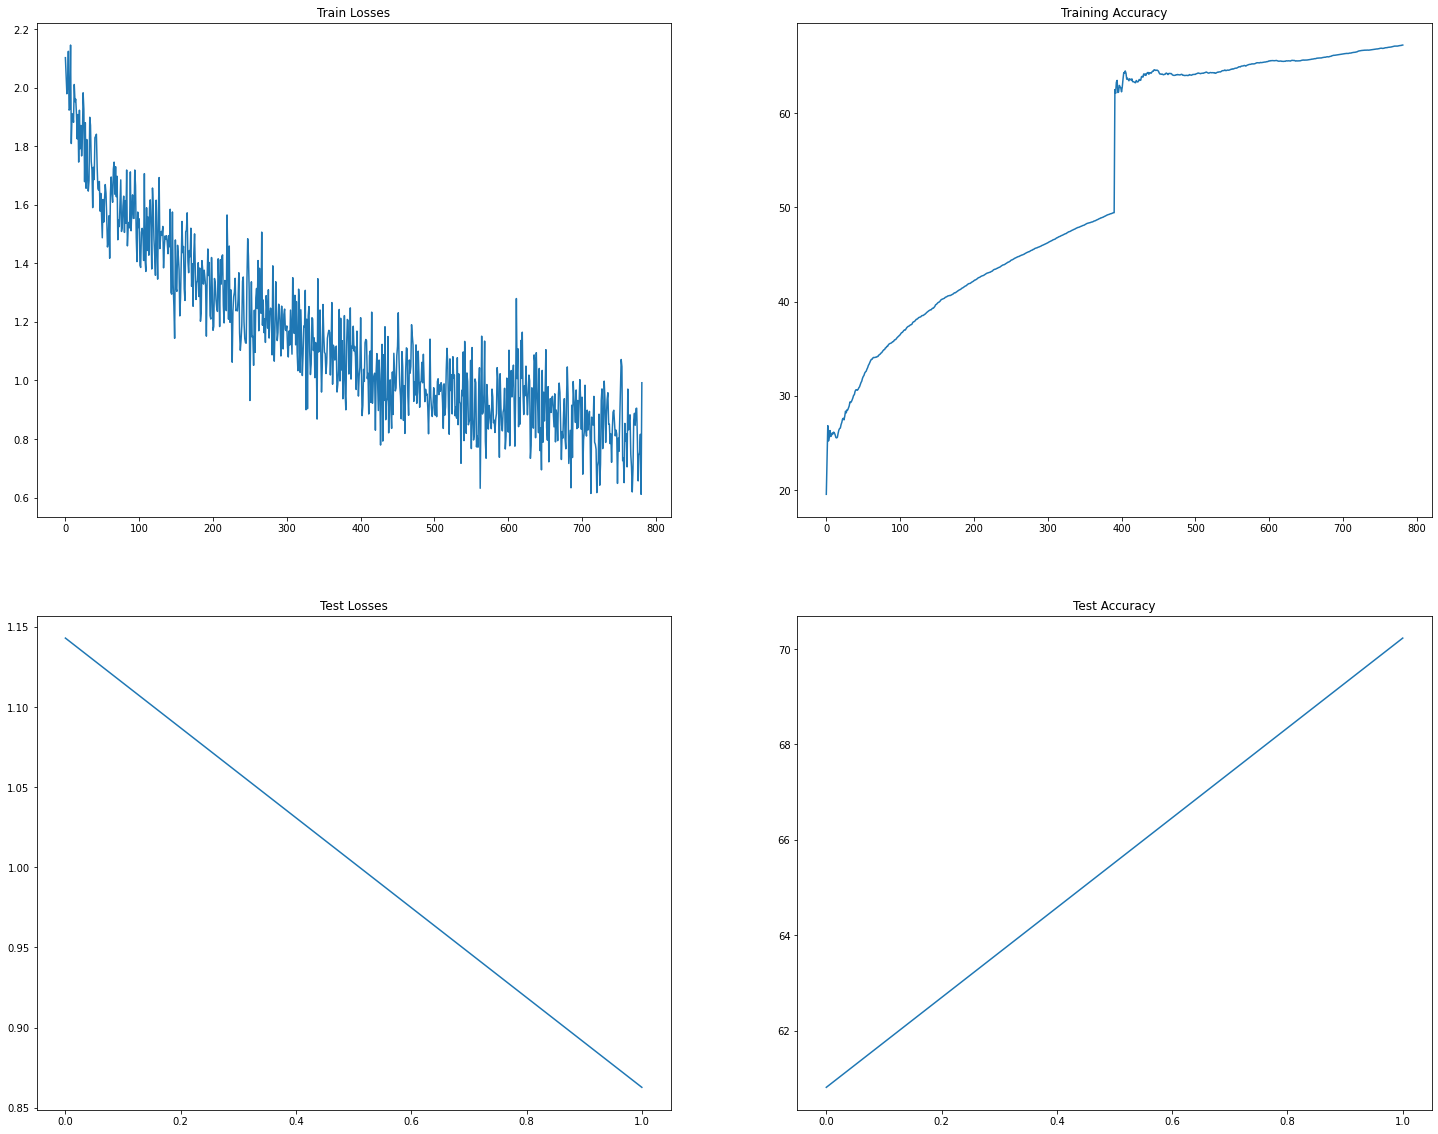

In [31]:
fig, axs = plt.subplots(2,2, figsize=(25,20))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')
trainlosses=[tensor.item() for tensor in train_losses]
axs[0,0].plot(trainlosses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)